# **Задание 2**

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с ***2023-01-31*** по ***2023-02-06*** включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 

## Подготовка к работе

In [5]:
# Подгружаем библиотеки и подключаемся к БД
import pandas as pd
import numpy as np
import pandahouse
from scipy import stats
import seaborn as sns

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230220',
                      'user':'student', 
                      'password':'dpo_python_2020'
}


## Загрузка данных

In [6]:
# Создание датафрейма
q = """
SELECT distinct user_id,
    exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes / views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2023-01-31' and '2023-02-06'
and exp_group in (1,2)
GROUP BY user_id, exp_group
"""
df = pandahouse.read_clickhouse(q, connection = connection)

df.head()

,user_id,exp_group,likes,views,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,26295,1,33,122,0.270492
4,18392,1,7,32,0.218750


**Гипотеза:** Выдвинем гипотезу, что при использовании нового алгоритма в экспериментальной группе 2 CTR увеличится. <br>
**Нулевая гипотеза:** средние значения CTR в контрольной и экспериментальной группaх равны. <br>
**Альтернативная гипотеза:** средние значения CTR в экспериментальной группе отличаются от значений в контрольной. <br>
**Пороговое значение p-value:** 0.05

## Посмотрим на распределение глазами


<AxesSubplot:xlabel='ctr', ylabel='Count'>

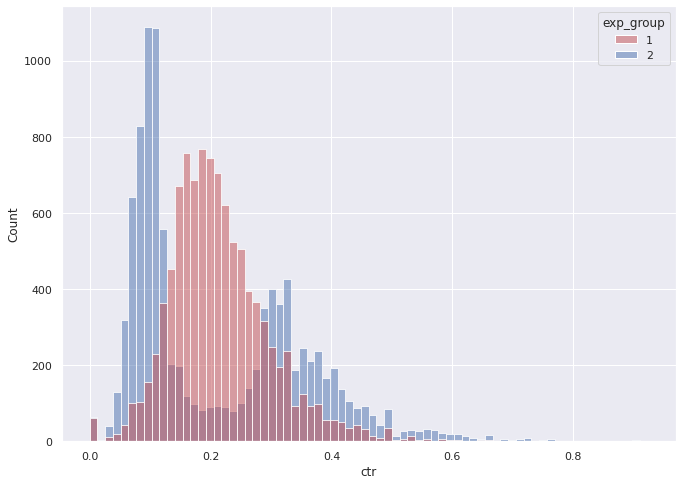

In [7]:
# Распределение ctr группы 1 и 2
sns.set(rc = {'figure.figsize':(11.0,8.0)})

sns.histplot(data = df,
             x = 'ctr',
             hue = 'exp_group',
             palette=['r','b'],
             alpha = 0.5
            )


Как мы видим, распределение группы 1 похоже на нормальное, а вот распределение группы 2 - нет! Распределения отличаются, давайте разбираться

## t-тест

In [8]:
# Сравнение параметричиским T-тестом
p_value = stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var = False)[1]
print('Отличие не покрасилось, p_value = ' + str(p_value) if p_value > 0.05
      else 'Отличие покрасилось, p_value = ' + str(p_value))

Отличие не покрасилось, p_value = 0.4780623130874935


## тест Манна-Уитни

In [9]:
# Сравнение непараметричиским U-критерием Манна — Уитни
p_value = stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                   df[df.exp_group == 2].ctr, 
                   alternative = 'two-sided')[1]
print('Отличие не покрасилось, p_value = ' + str(p_value) if p_value > 0.05
      else 'Отличие покрасилось, p_value = ' + str(p_value))

Отличие покрасилось, p_value = 6.0376484617779035e-56


t-тест сработал неправильно из-за неномрального распределения 2 группы, а тест Манна-Уитни позволяет нам отменить нулевую гипетезу и принять альтернативную гипетезу. <br>
**Вывод:** средние значения CTR скорее всего в экпериментальной группе выше значений в контрольной, исследуем дальше

## Сглаженный CTR

<AxesSubplot:xlabel='ctr'>

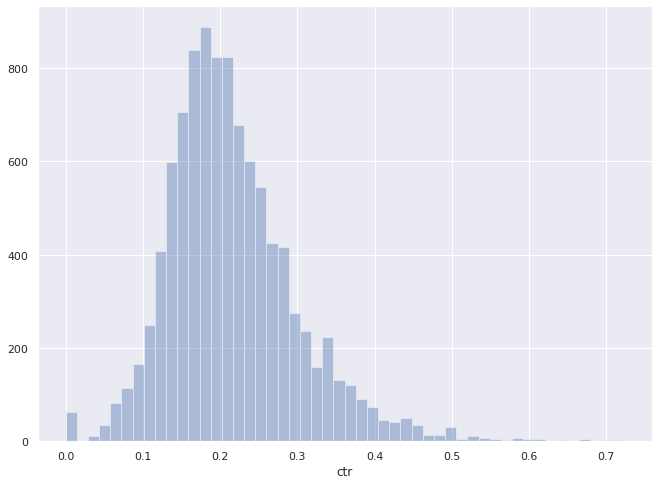

In [12]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smoothed_ctr = (user_likes + global_ctr * alpha) / (user_views + alpha)
    return smoothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum() / df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

sns.distplot(group1.ctr, 
            kde = False)

<AxesSubplot:xlabel='smoothed_ctr'>

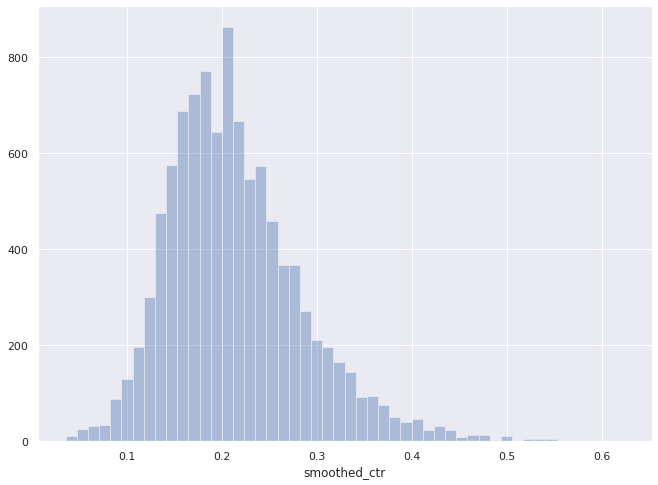

In [13]:
# Добавим колонку smoothed_ctr
group1['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x.likes, x.views, global_ctr_1, 5), axis = 1)

group2['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x.likes, x.views, global_ctr_2, 5), axis = 1)

sns.distplot(group1.smoothed_ctr,
             kde = False)

<AxesSubplot:xlabel='smoothed_ctr'>

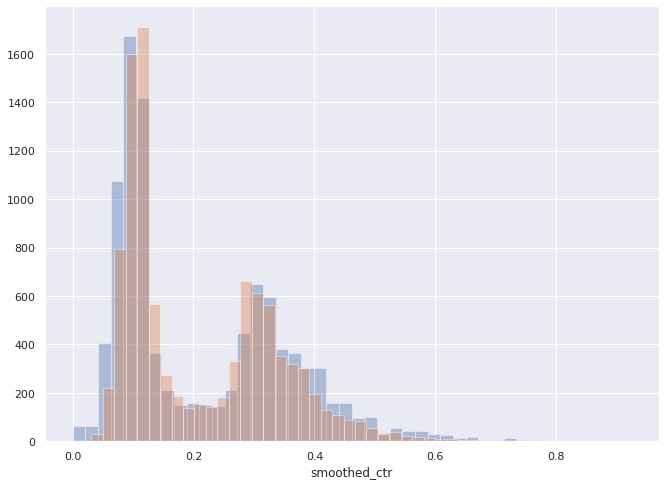

In [14]:
# Посмотрим как изменились данные после сглаживания
sns.distplot(group2.ctr, 
            kde = False)
sns.distplot(group2.smoothed_ctr,
             kde = False)

## t-тест на сглаженном CTR

<AxesSubplot:xlabel='smoothed_ctr'>

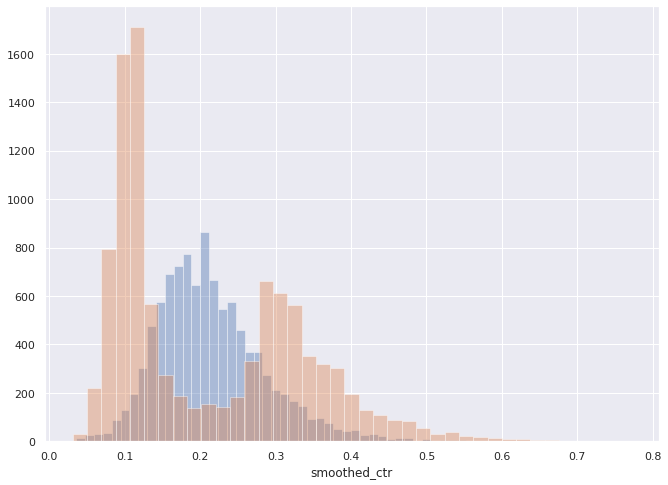

In [15]:
# Визуализация сглаженных ctr у двух групп
sns.distplot(group1.smoothed_ctr, 
            kde = False)
sns.distplot(group2.smoothed_ctr,
             kde = False)

In [16]:
# Сравнение параметричиским T-тестом
p_value = stats.ttest_ind(group1.smoothed_ctr,
                          group2.smoothed_ctr,
                          equal_var = False)[1]
print('Отличие не покрасилось, p_value = ' + str(p_value) if p_value > 0.05
      else 'Отличие покрасилось, p_value = ' + str(p_value))

Отличие покрасилось, p_value = 0.0223769815558559


t-тест на сглаженном ctr сработал лучше t-теста на изначальных данных. Тест однозначно показывает p-value значительно < 0.05, что позволяет нам отменить нулевую гипетезу и принять альтернативную гипетезу. <br>
**Вывод:** средние значения CTR в экпериментальной группе отличаются от значений в контрольной

## Пуассоновский бутстреп

<AxesSubplot:ylabel='Count'>

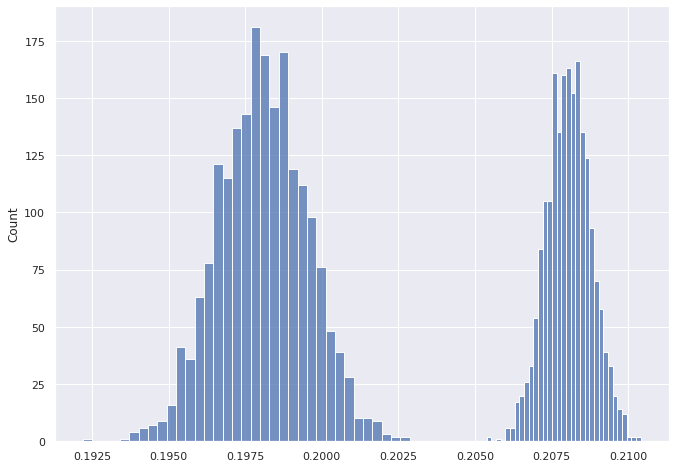

In [17]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap = 2000):
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    globalctr1 = (poisson_bootstraps1*likes1).sum(axis=1) / (poisson_bootstraps1*views1).sum(axis=1)
    globalctr2 = (poisson_bootstraps2*likes2).sum(axis=1) / (poisson_bootstraps2*views2).sum(axis=1)
    return globalctr1, globalctr2

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

# Сохраним полученные bootstrap-распределения CTR в переменные
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

# Распределения ctr групп 1 и 2
sns.histplot(ctr1)
sns.histplot(ctr2)

Выборки не пересекаются

<AxesSubplot:ylabel='Count'>

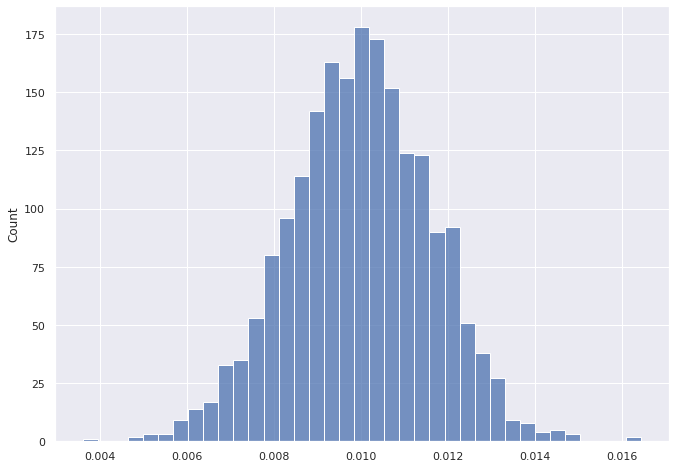

In [18]:
# Распределение разности ctr групп 1 и 2
sns.histplot(ctr1 - ctr2)

In [23]:
print(stats.ttest_ind(ctr1, ctr2, equal_var = False))
print(stats.mannwhitneyu(ctr1, ctr2, alternative='two-sided'))
                

Ttest_indResult(statistic=274.74388406098643, pvalue=0.0)
MannwhitneyuResult(statistic=4000000.0, pvalue=0.0)


Используя метод bootstrap мы получили распределения общего CTR для групп 1 и 2. Еще на этапе визуализации можно было бы с достаточной уверенностью утверждать, что средние CTR в группе 1 выше значений в группе 2. p-value равное 0 в обоих критериях только подтверждает это, что позволяет нам отменить нулевую гипетезу и принять альтернативную гипетезу.

## Бакетное преобразование

In [127]:
q = """
select exp_group, bucket, 
sum(likes)/sum(views) as bucket_ctr
from (select exp_group, xxHash64(user_id)%50 as bucket,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes / views as ctr
from {db}.feed_actions
WHERE toDate(time) between '2023-01-31' and '2023-02-06'
and exp_group in (1,2)
GROUP BY user_id, exp_group)
group by exp_group, bucket
"""

df=pandahouse.read_clickhouse(q, connection = connection)

df.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


## t-тест

In [131]:
# Сравнение параметричиским T-тестом
p_value = stats.ttest_ind(df[df.exp_group == 1].bucket_ctr,
                df[df.exp_group == 2].bucket_ctr,
                equal_var = False)[1]
print('Отличие не покрасилось, p_value = ' + str(p_value) if p_value > 0.05
      else 'Отличие покрасилось, p_value = ' + str(p_value))

Отличие покрасилось, p_value = 3.4455951649945907e-07


## тест Манна-Уитни

In [132]:
# Сравнение непараметричиским U-критерием Манна — Уитни
p_value = stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr,
                   df[df.exp_group == 2].bucket_ctr,
                   alternative='two-sided')[1]
print('Отличие не покрасилось, p_value = ' + str(p_value) if p_value > 0.05
      else 'Отличие покрасилось, p_value = ' + str(p_value))

Отличие покрасилось, p_value = 2.859963936492646e-07


Используя метод бакетного преобразования и примененных статистических тестов, можно отклонить нулевую гипотезу и принять альтернативную

## Проведем контрольную проверку, что новый алгоритм не привел к тому, что сократилось число просмотров у пользователей. Типичная ситуация в АB-тестах — вырастили число лайков, но уменьшили число просмотров.

66.14851286173634


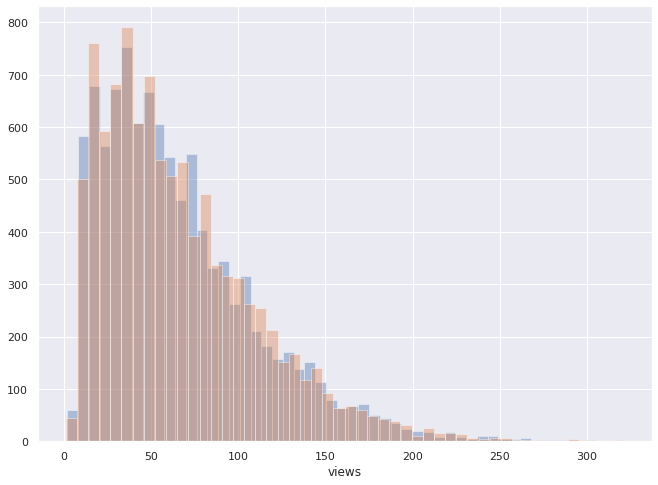

In [43]:
q = """
SELECT distinct user_id,
    exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes / views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2023-01-31' and '2023-02-06'
and exp_group in (1,2)
GROUP BY user_id, exp_group
"""
df = pandahouse.read_clickhouse(q, connection = connection)
print(df[df.exp_group == 2].views.mean())
sns.set(rc = {'figure.figsize':(11.0,8.0)})

# Распределение просмотров в группе 1 b2
sns.distplot(df[df.exp_group == 1].views, kde = False);
sns.distplot(df[df.exp_group == 2].views, kde = False);

Распределение далеко от нормального, поэтому сравнение выборок пока возможно провести только непараметрическими методами. Но попробуем как-то поработать с ним.

<AxesSubplot:xlabel='views'>

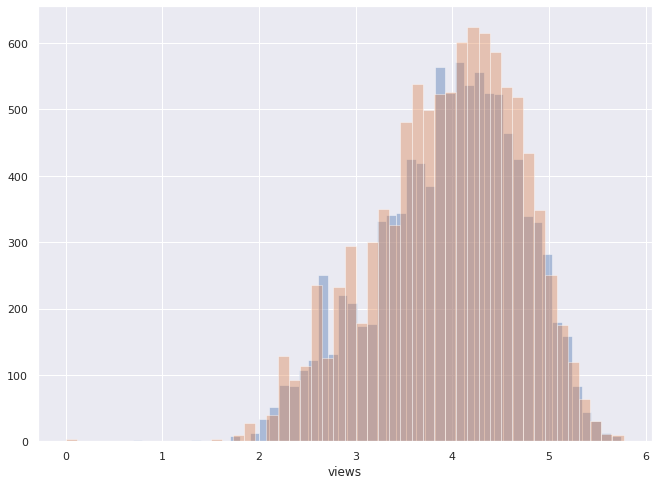

In [35]:
sns.distplot(np.log(df[df.exp_group == 1].views), kde = False)
sns.distplot(np.log(df[df.exp_group == 2].views), kde = False)

Распределения в в обоих группах стали заметно больше походить на нормальные. Хотя и далеки от идеального, попробуем поработать с ними.

**Гипотеза:** Выдвинем новую гипотезу, что в группе 2 в сравнении с группой 1 уменьшилось число просмотров <br>
**Нулевая гипотеза:** число просмотров в экспериментальной группе равно или больше, нежели в контрольной группе<br>
**Альтернативная гипотеза:** число просмотров в экспериментальной группе меньше, чем в контрольной.<br>
**Пороговое значение p-value:** 0.05

In [77]:
# Сравнение непараметричиским U-критерием Манна — Уитни
stats.mannwhitneyu(np.log(df[df.exp_group == 2].views), np.log(df[df.exp_group == 1].views), alternative='less')

MannwhitneyuResult(statistic=49994123.5, pvalue=0.3488124463375471)

In [79]:
# Сравнение параметричиским T-тестом
stats.ttest_ind(np.log(df[df.exp_group == 2].views), np.log(df[df.exp_group == 1].views), equal_var=False, alternative='less')

Ttest_indResult(statistic=-0.6715621845844871, pvalue=0.25093510483867126)

**Вывод:** новый алгоритм не привел к снижению количества просмотров в экспериментальной группе.

## Проведем контрольную проверку, что новый алгоритм не привел к тому, что сократилось число лайков у пользователей.

**Гипотеза:** Выдвинем новую гипотезу, что в группе 2 в сравнении с группой 1 уменьшилось число просмотров <br>
**Нулевая гипотеза:** число лайков в экспериментальной группе равно или больше, нежели в контрольной группе<br>
**Альтернативная гипотеза:** число лайков в экспериментальной группе меньше, чем в контрольной.<br>
**Пороговое значение p-value:** 0.05

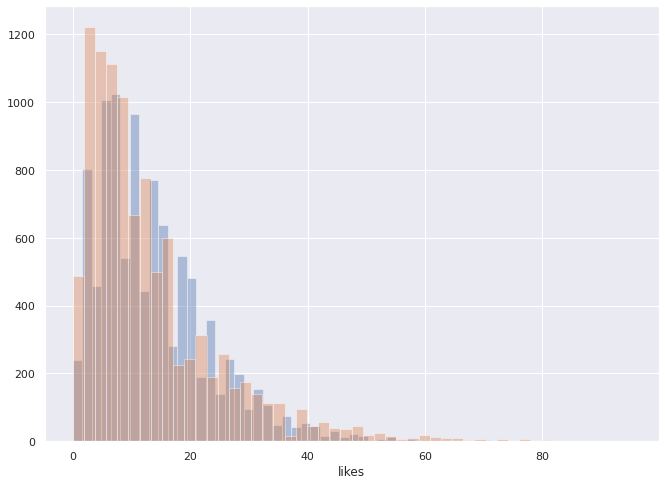

In [71]:
sns.distplot(df[df.exp_group == 1].likes, kde = False);
sns.distplot(df[df.exp_group == 2].likes, kde = False);

In [86]:
# Сравнение непараметричиским U-критерием Манна — Уитни
stats.mannwhitneyu(df[df.exp_group == 2].likes, df[df.exp_group == 1].likes, alternative='less')

MannwhitneyuResult(statistic=44792538.0, pvalue=1.4300962888572648e-39)

**Вывод:** новый алгоритм привел к снижению количества лайков в экспериментальной группе.

## Подытожим

- exp_group = 1 - Все по-старому <br>
- exp_group = 2 - Рекомендации "похожих на лайкнутые постов"

Посмотрев на распределение глазами, можно сказать, что у 2 группы большая часть значений CTR ухудшилось по сравнению с 1 группой. Также распределение группы 1 близко к нормальному, а группы 2 нет - тут мы видим два горба у распределения. Ввиду этого, t-тест скорее покажет неправильные результаты из-за его требовательности к распределению. 

Это можно проверить: t-тест и тест Манна-Уитни показывают разные результаты: t-тест говорит, что отличий в распределений нет, а тест Манна-Уитни - различия есть. t-тест на сглаженном CTR проявил себя правильно: отличие покрасилось. bootstrap показал, что CTR группы 1 выше, чем у группы 2 в среднем на 0.1, что есть звоночек к тому, что нам не следует принимать новый алгоритм. Метод бакетных преобразований и статистические тесты сказали нам о тех же результатах. 

Дополнительно были введены гипотезы по изменению количества лайков и просмотров у разных групп. Статистические тесты показали, что между 1 и 2 группой нет статистически значимых различий по просмотрам, однако есть статистически значимая разница по лайкам. Так, у 2 группы лайков меньше, чем у 1 группы

*Возможная причина неудачного алгоритма рекомендаций* - видимо пользователю не нравится видеть однотипные посты, которые он лайкал, поэтому их количество упало

**Вывод:** раскатывать новый алгоритм все-таки не стоит